In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
from datetime import datetime, timedelta
from tqdm import tqdm

from qfin.assets import *
from qfin.models import BlackScholesModel, HestonModel, VarianceGammaModel, SVJModel, SVCJModel, CGMYModel, MertonModel, KDEModel
from qfin.hedges import *
from qfin.period import Period
from qfin.volsurf import VolatilitySurface
from qfin.utils import bs_explicit_call

In [58]:
vs = VolatilitySurface.from_date(datetime(2019, 4, 1))
vs.calibrate()
bs_explicit_call(30/365, 4000, 4088.16, 0., vs.iv(30/365, 4088.16/4000)), \
bs_explicit_call(90/365, 4000, 4088.16, 0., vs.iv(90/365, 4088.16/4000))

INFO:qfin.volsurf.volsurf:>> Calibrating 20190401 SVI volatility surface.
INFO:qfin.volsurf.volsurf:Finished.


(252.20257551696477, 456.07421989330123)

In [59]:
vs = VolatilitySurface.from_date(datetime(2019, 10, 1))
vs.calibrate()
bs_explicit_call(30/365, 8000, 8367.51, 0., vs.iv(30/365, 8367.51/8000)), \
bs_explicit_call(90/365, 8000, 8367.51, 0., vs.iv(90/365, 8367.51/8000))

INFO:qfin.volsurf.volsurf:>> Calibrating 20191001 SVI volatility surface.
INFO:qfin.volsurf.volsurf:Finished.


(1008.680099883979, 1605.1569027255564)

In [60]:
vs = VolatilitySurface.from_date(datetime(2020, 2, 1))
vs.calibrate()
bs_explicit_call(30/365, 10000, 9804.85, 0., vs.iv(30/365, 9804.85/10000)), \
bs_explicit_call(90/365, 10000, 9804.85, 0., vs.iv(90/365, 9804.85/10000))

INFO:qfin.volsurf.volsurf:>> Calibrating 20200201 SVI volatility surface.
INFO:qfin.volsurf.volsurf:Finished.


(521.3378043601779, 1115.7723058164538)

In [3]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [4]:
black_scholes = BlackScholesModel()
heston = HestonModel()
variance_gamma = VarianceGammaModel()
svj = SVJModel()
svcj = SVCJModel()
cgmy = CGMYModel()
merton = MertonModel()

In [5]:
t0 = datetime.strptime('20190401', '%Y%m%d')
t1 = datetime.strptime('20191001', '%Y%m%d')
t2 = datetime.strptime('20200201', '%Y%m%d')
t3 = datetime.strptime('20200701', '%Y%m%d')

# Bullish

* 2 path models
* 7 hedge models
* 4 hedges
* 3 periods
* 3 strikes
* 2 maturities

In [7]:
periods = [
    {
        'period': Period(t0, t1, 'BULLISH'),
        's0': 4088.16,
        'maturities': [30, 90],
        'strikes': [3000, 4000, 5000],
        # 'strikes': [4000],
        'hedge_strike': 4500,
        'rate': 0,
    },
    {
        'period': Period(t1, t2, 'CALM'),
        's0': 8367.51,
        'maturities': [30, 90],
        'strikes': [7000, 8000, 9000],
        # 'strikes': [8000],
        'hedge_strike': 8500,
        'rate': 0,
    },
    {
        'period': Period(t2, t3, 'COVID'),
        's0': 9804.85,
        'maturities': [30, 90],
        'strikes': [9000, 10000, 11000],
        # 'strikes': [10000],
        'hedge_strike': 10500,
        'rate': 0,
    },
]

In [8]:
def get_returns(period, interval):
    
    date_range = pd.date_range(period.t0 - timedelta(days=INTERVAL), period.t1)
    df = pd.read_csv("_input/BTCUSDT.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    returns = np.log(df['Close']).diff()
    returns = returns.dropna()
    returns = returns.loc[date_range]
    
    return returns

In [9]:
directory = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")
directory

'20210705_225914'

# Calculate and store option prices

In [10]:
rows = []

for entry in periods:
    
    period = entry['period']
    strikes = entry['strikes']
    maturities = entry['maturities']
    s0 = entry['s0']
    rate = entry['rate']
    
    vs = VolatilitySurface.from_date(period.t0, svi_caching=True)
    vs.calibrate()

    for strike in strikes:
        for maturity in maturities:
            title = f"{period.name}__{strike}__{maturity}"
            ttm = maturity / 365
            v0 = bs_explicit_call(ttm, strike, s0, rate, vs.iv(ttm, strike/s0))
            rows += [[title, v0]]
            
df = pd.DataFrame(rows, columns=['label', 'price'])
df.to_csv('_output/hedges/pnl/20210228_021905/__prices.csv')

INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
df = pd.read_csv('_output/hedges/pnl/20210228_021905/__prices.csv')
prices = dict(df[['label', 'price']].to_numpy())
prices

{'BULLISH__3000__30': 1093.382907286154,
 'BULLISH__3000__90': 1154.0950685543946,
 'BULLISH__4000__30': 251.26970958464926,
 'BULLISH__4000__90': 459.6577998023943,
 'BULLISH__5000__30': 25.578534653964308,
 'BULLISH__5000__90': 149.3337705448864,
 'CALM__7000__30': 1683.3371516096674,
 'CALM__7000__90': 2150.9136782014625,
 'CALM__8000__30': 1027.5288781975567,
 'CALM__8000__90': 1614.7894105830364,
 'CALM__9000__30': 578.6638617958506,
 'CALM__9000__90': 1203.0870093962205,
 'COVID__9000__30': 1078.8945271519497,
 'COVID__9000__90': 1594.7133019960238,
 'COVID__10000__30': 528.3563145012513,
 'COVID__10000__90': 1121.7790306194247,
 'COVID__11000__30': 257.87185767583384,
 'COVID__11000__90': 795.9703977791072}

# Create hedges

In [13]:
np.random.seed(1337)

# model inputs
npaths = 100000

hedges = []

for entry in periods:

    period, s0, all_days, strikes, hedge_strike, rate = entry.values()
    
    # init kde model
    
    INTERVAL = 365
    returns = get_returns(period, INTERVAL)

    kde = KDEModel(INTERVAL)
    kde.calibrate(returns)
    
    # init underlyings
    
    underlyings = [
        Spot(s0, rate, svcj, period, npaths),
        Spot(s0, rate, kde, period, npaths),
    ]
    
    vs = VolatilitySurface.from_date(period.t0, svi_caching=True)
    vs.calibrate()

    for underlying in underlyings:

        for days in all_days:

            maturity = period.t0 + timedelta(days=days)
            another_call = Call(underlying, maturity, hedge_strike, underlying.model, period, npaths)
            
            for strike in strikes:

                ttm, moneyness = days/365, strike/s0
                iv = vs.iv(ttm, moneyness)
                v0 = bs_explicit_call(ttm, strike, s0, rate, iv)
                                
                for model in black_scholes, heston, variance_gamma, svj, svcj, cgmy, merton:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [DeltaHedge(call, [underlying], v0, days, directory)]

                for model in black_scholes, heston, variance_gamma, svj, svcj, cgmy, merton:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [DeltaGammaHedge(call, [underlying, another_call], v0, days, directory)]

                for model in black_scholes, merton, heston, svj, svcj:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [DeltaVegaHedge(call, [underlying, another_call], v0, days, directory)]

                for model in merton, heston, svj, svcj:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [MinimumVarianceHedge(call, [underlying], v0, days, directory)]

# Initialize (load or generate) paths of all underlying used in hedging

start with spots, since the spot paths are required to generate the corresponding call paths

In [16]:
assets = sorted(set([asset for hedge in hedges for asset in hedge.assets]), key=lambda x: type(x) == Call)

for asset in tqdm(assets):
    asset.init()

  0%|          | 0/18 [00:00<?, ?it/s]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__COVID__SPOT__100000 paths.
INFO:qfin.assets.asset:100000 spot paths (115.2MiB) written to _output/hedges/paths/PATHS__SVCJ__COVID__SPOT__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__COVID__SPOT__100000.pdf.


  6%|▌         | 1/18 [01:39<28:16, 99.78s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__CALM__SPOT__100000 paths.
INFO:qfin.assets.asset:100000 spot paths (93.8MiB) written to _output/hedges/paths/PATHS__SVCJ__CALM__SPOT__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__CALM__SPOT__100000.pdf.


 11%|█         | 2/18 [03:01<25:07, 94.23s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__CALM__SPOT__100000 paths.
INFO:qfin.assets.asset:100000 spot paths (93.8MiB) written to _output/hedges/paths/PATHS__KDE__CALM__SPOT__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__CALM__SPOT__100000.pdf.


 17%|█▋        | 3/18 [04:11<21:48, 87.22s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__COVID__SPOT__100000 paths.
INFO:qfin.assets.asset:100000 spot paths (115.2MiB) written to _output/hedges/paths/PATHS__KDE__COVID__SPOT__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__COVID__SPOT__100000.pdf.


 22%|██▏       | 4/18 [05:39<20:23, 87.43s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__BULLISH__SPOT__100000 paths.
INFO:qfin.assets.asset:100000 spot paths (139.6MiB) written to _output/hedges/paths/PATHS__SVCJ__BULLISH__SPOT__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__BULLISH__SPOT__100000.pdf.


 28%|██▊       | 5/18 [07:39<21:02, 97.14s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__BULLISH__SPOT__100000 paths.
INFO:qfin.assets.asset:100000 spot paths (139.6MiB) written to _output/hedges/paths/PATHS__KDE__BULLISH__SPOT__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__BULLISH__SPOT__100000.pdf.


 33%|███▎      | 6/18 [09:23<19:49, 99.13s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__BULLISH__BTC-30JUN19-4500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.p

INFO:qfin.assets.asset:100000 spot paths (139.6MiB) written to _output/hedges/paths/PATHS__SVCJ__BULLISH__BTC-30JUN19-4500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__BULLISH__BTC-30JUN19-4500-C__100000.pdf.


 39%|███▉      | 7/18 [11:47<20:38, 112.58s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__BULLISH__BTC-30JUN19-4500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.p

INFO:qfin.assets.asset:100000 spot paths (139.6MiB) written to _output/hedges/paths/PATHS__KDE__BULLISH__BTC-30JUN19-4500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__BULLISH__BTC-30JUN19-4500-C__100000.pdf.


 44%|████▍     | 8/18 [14:11<20:21, 122.15s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__COVID__BTC-1MAY20-10500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: Runtime

INFO:qfin.assets.asset:100000 spot paths (115.2MiB) written to _output/hedges/paths/PATHS__SVCJ__COVID__BTC-1MAY20-10500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__COVID__BTC-1MAY20-10500-C__100000.pdf.


 50%|█████     | 9/18 [16:27<18:55, 126.22s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__CALM__BTC-31OCT19-8500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: Runtime

INFO:qfin.assets.asset:100000 spot paths (93.8MiB) written to _output/hedges/paths/PATHS__KDE__CALM__BTC-31OCT19-8500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__CALM__BTC-31OCT19-8500-C__100000.pdf.


 56%|█████▌    | 10/18 [17:55<15:17, 114.72s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__COVID__BTC-1MAY20-10500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: Runtime

INFO:qfin.assets.asset:100000 spot paths (115.2MiB) written to _output/hedges/paths/PATHS__KDE__COVID__BTC-1MAY20-10500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__COVID__BTC-1MAY20-10500-C__100000.pdf.


 61%|██████    | 11/18 [20:10<14:05, 120.78s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__BULLISH__BTC-1MAY19-4500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.p

INFO:qfin.assets.asset:100000 spot paths (139.6MiB) written to _output/hedges/paths/PATHS__SVCJ__BULLISH__BTC-1MAY19-4500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__BULLISH__BTC-1MAY19-4500-C__100000.pdf.


 67%|██████▋   | 12/18 [22:12<12:06, 121.05s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__CALM__BTC-31OCT19-8500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: Runtime

INFO:qfin.assets.asset:100000 spot paths (93.8MiB) written to _output/hedges/paths/PATHS__SVCJ__CALM__BTC-31OCT19-8500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__CALM__BTC-31OCT19-8500-C__100000.pdf.


 72%|███████▏  | 13/18 [23:38<09:12, 110.56s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__CALM__BTC-30DEC19-8500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning:

INFO:qfin.assets.asset:100000 spot paths (93.8MiB) written to _output/hedges/paths/PATHS__SVCJ__CALM__BTC-30DEC19-8500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__CALM__BTC-30DEC19-8500-C__100000.pdf.


 78%|███████▊  | 14/18 [25:26<07:20, 110.00s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__BULLISH__BTC-1MAY19-4500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.p

INFO:qfin.assets.asset:100000 spot paths (139.6MiB) written to _output/hedges/paths/PATHS__KDE__BULLISH__BTC-1MAY19-4500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__BULLISH__BTC-1MAY19-4500-C__100000.pdf.


 83%|████████▎ | 15/18 [27:27<05:39, 113.32s/it]

INFO:qfin.assets.asset:Generating PATHS__SVCJ__COVID__BTC-2MAR20-10500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: Runtime

INFO:qfin.assets.asset:100000 spot paths (115.2MiB) written to _output/hedges/paths/PATHS__SVCJ__COVID__BTC-2MAR20-10500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__SVCJ__COVID__BTC-2MAR20-10500-C__100000.pdf.


 89%|████████▉ | 16/18 [29:21<03:46, 113.32s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__COVID__BTC-2MAR20-10500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning: invalid value encountered in multiply
  d1 = (np.log(spot / strike) + (rate - dividends + SIGMA ** 2 / 2) * ttm) / SIGMA / np.sqrt(ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:9: RuntimeWarning: invalid value encountered in multiply
  d2 = d1 - SIGMA * np.sqrt(ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: Runtime

INFO:qfin.assets.asset:100000 spot paths (115.2MiB) written to _output/hedges/paths/PATHS__KDE__COVID__BTC-2MAR20-10500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__COVID__BTC-2MAR20-10500-C__100000.pdf.


 94%|█████████▍| 17/18 [31:13<01:52, 113.00s/it]

INFO:qfin.assets.asset:Generating PATHS__KDE__CALM__BTC-30DEC19-8500-C__100000 paths.


/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/RDC/maticjov/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/home/RDC/maticjov/projects/hedging_cc/qfin/volsurf/volsurf.py:140: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)
/home/RDC/maticjov/projects/hedging_cc/qfin/utils.py:8: RuntimeWarning:

INFO:qfin.assets.asset:100000 spot paths (93.8MiB) written to _output/hedges/paths/PATHS__KDE__CALM__BTC-30DEC19-8500-C__100000.csv.
INFO:qfin.assets.asset:Plot written to _output/hedges/paths/PATHS__KDE__CALM__BTC-30DEC19-8500-C__100000.pdf.


100%|██████████| 18/18 [33:01<00:00, 110.09s/it]


In [18]:
!pip3 install multiprocess

In [21]:
import multiprocessing as mp

# Run the hedges

In [ ]:
import multiprocessing as mp

MULTIPROCESSING = True

results = []

def callback(retval):
    results.append(retval)
    progress = len(results) / len(hedges)
    print(f"\r{progress:7.2%}", end='')
    
def run(hedge):
    hedge.execute()
    
if MULTIPROCESSING:

    p = mp.Pool(mp.cpu_count()-2)

    for hedge in hedges:
        p.apply_async(run, args=(hedge, ), callback=callback)

    p.close()
    p.join()

else:

    for hedge in hedges:
        callback(run(hedge))

# Single hedge separately

In [73]:
directory = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")

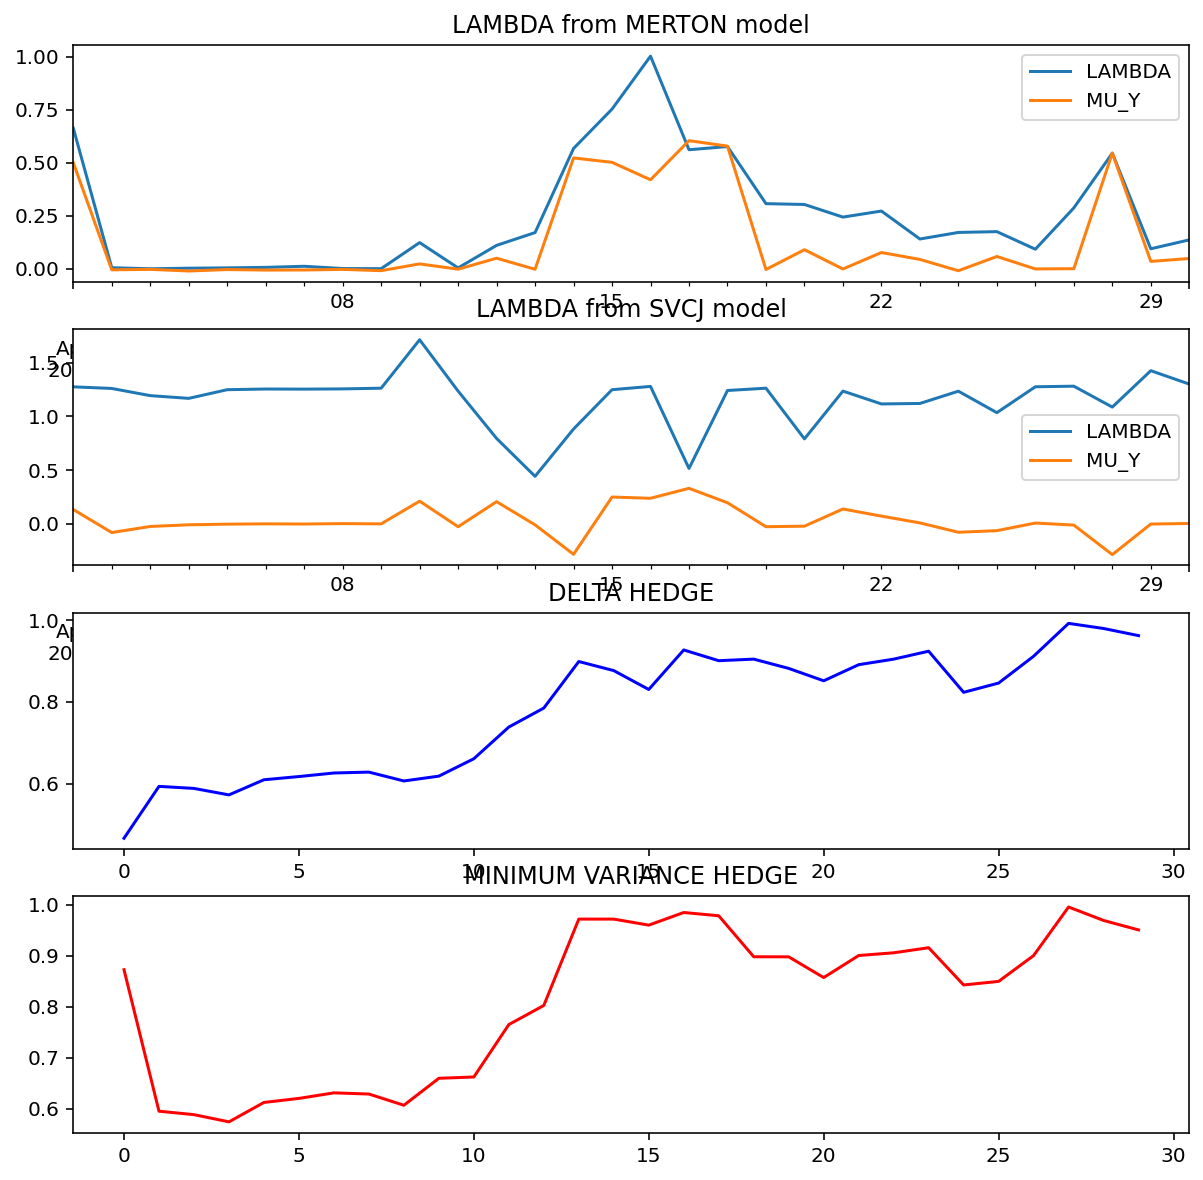

In [237]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 10))

model = MertonModel()
ax1.set_title("LAMBDA from MERTON model")
model.parameters(period.date_range)[['LAMBDA', 'MU_Y']].iloc[:30].plot(ax=ax1)

model = SVCJModel()
ax2.set_title("LAMBDA from SVCJ model")
model.parameters(period.date_range)[['LAMBDA', 'MU_Y']].iloc[:30].plot(ax=ax2)

idx = 1
ax3.set_title('DELTA HEDGE')
ax3.plot(hedges[0].strategies[0, idx, :30], c='b')

ax4.set_title('MINIMUM VARIANCE HEDGE')
ax4.plot(hedges[1].strategies[0, idx, :30], c='r')

INFO:qfin.assets.asset:Loading PATHS__SVCJ__BULLISH__SPOT__100000 paths from file.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__DeltaHedge__BULLISH__4000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__DeltaHedge__BULLISH__4000__30__100000.pdf.
INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__100000.pdf.


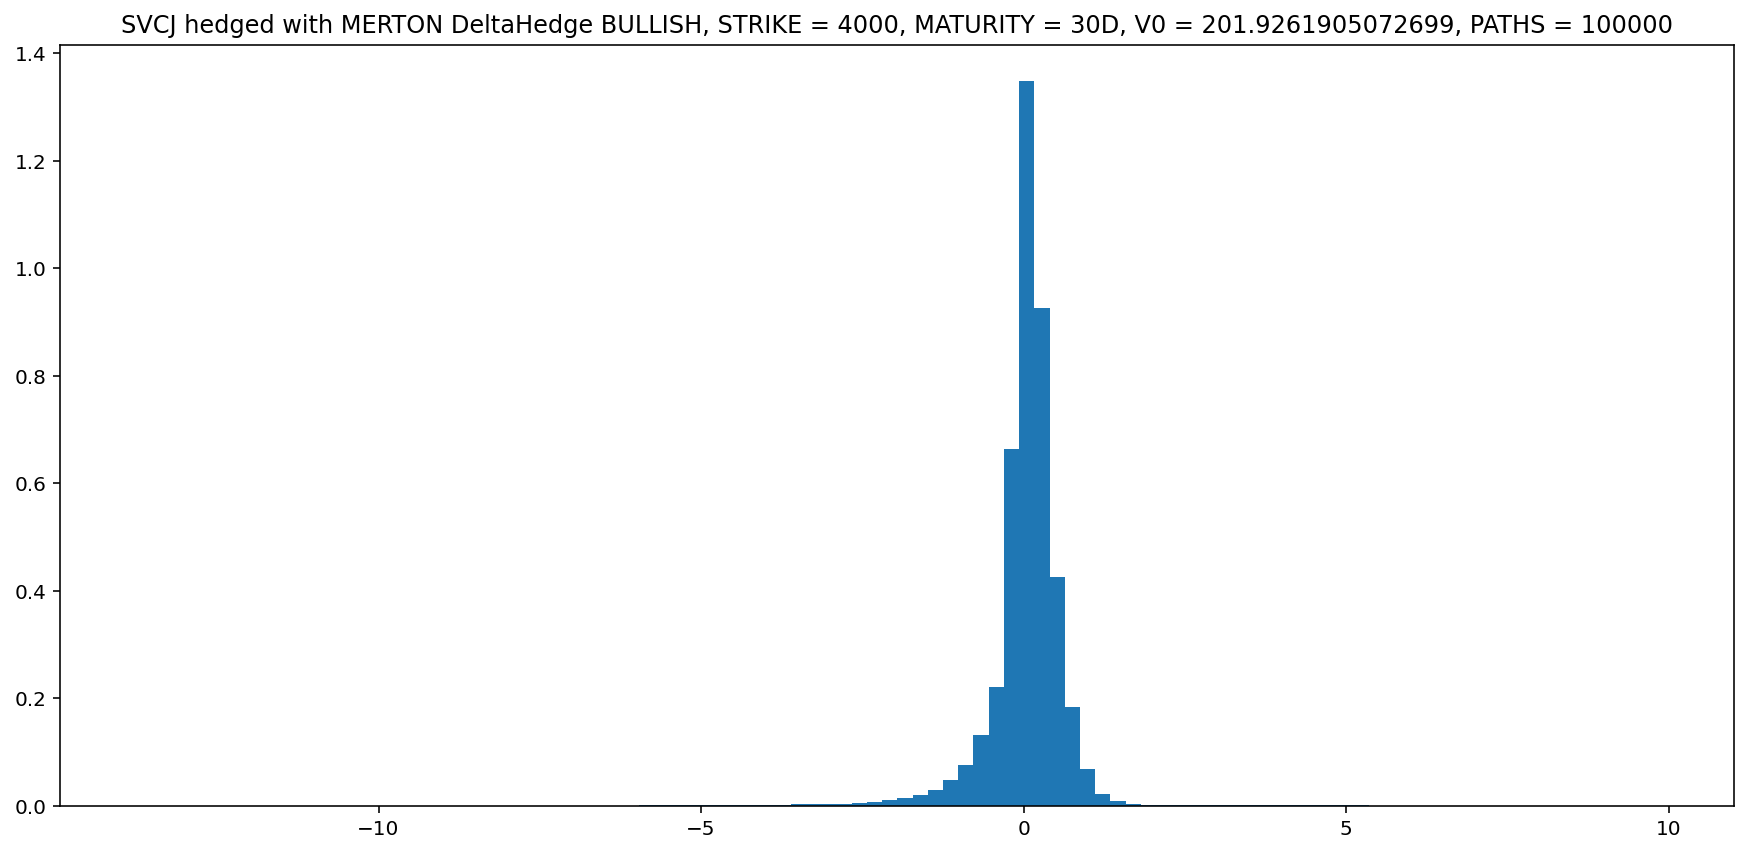

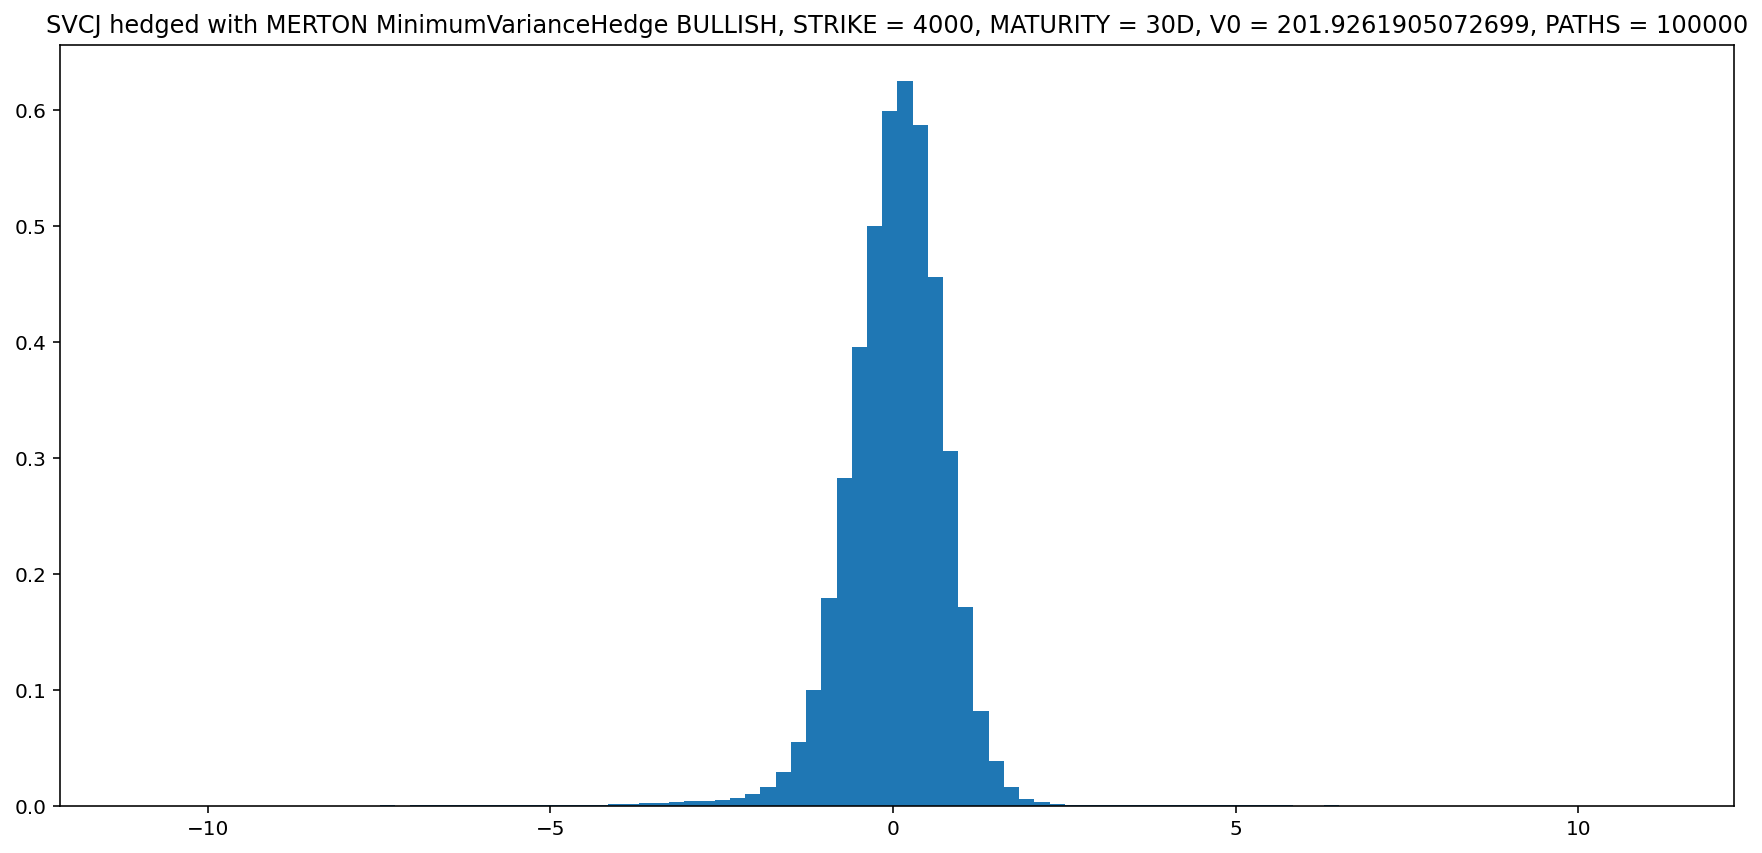

In [243]:
s0 = 4000
rate = 0.
days = 30
period = Period(t0, t1, 'BULLISH')
svcj = SVCJModel()
npaths = 10000
maturity = period.t0 + timedelta(days=days)
strike = 4000
model = MertonModel()

vs = VolatilitySurface.from_date(period.t0, svi_caching=True)
vs.calibrate()

ttm, moneyness = days/365, strike/s0
iv = vs.iv(ttm, moneyness)
v0 = bs_explicit_call(ttm, strike, s0, rate, vs.iv(ttm, strike/s0))

underlying = Spot(s0, rate, svcj, period, npaths)
underlying.init()

call = Call(underlying, maturity, strike, model, period, npaths)

hedges = [
    DeltaHedge(call, [underlying], v0, days, directory),
    MinimumVarianceHedge(call, [underlying], v0, days, directory),
]

for hedge in hedges:
    hedge.execute()

In [244]:
pnl = pd.read_csv(f'/Users/konstantinisstarovoitovs/projects/chris/_output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__DeltaHedge__BULLISH__4000__30__10000.csv', header=None)[0]
delta = np.std(pnl)

pnl = pd.read_csv(f'/Users/konstantinisstarovoitovs/projects/chris/_output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__10000.csv', header=None)[0]
mv = np.std(pnl)

delta, mv

(115.61418306135347, 148.0064348314221)

# Analyze

In [21]:
idx = np.argmin(hedge.pnl)
print(idx, hedge.pnl[idx])

2302 -62019.79831617395


In [ ]:
print("Standard error:")

for hedge in hedges:
    print(f"{hedge.name}: {np.std(hedge.pnl)}")

print("\n1 path pnl:")

for hedge in hedges:
    print(f"{hedge.name}: {hedge.pnl[idx]}")

fig, ax = plt.subplots(nrows=1 + len(hedges), figsize=(10, 1 + 4 * len(hedges)))

ax[0].set_title("ASSETS")
ax[0].plot(hedges[0].assets[0].paths[idx, :days+1], c='b')

for idy, hedge in enumerate(hedges):
    
    ax[idy+1].set_title(hedge.name)
    ax[idy+1].plot(hedge.strategies[0, idx, :], c='b')    
    
    for strategy in hedge.strategies[1:]:
        ax[idy+1].twinx().plot(strategy[idx, :], c='r')